In [21]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numba
from numba import jit, njit, cuda
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
from matplotlib import ticker
#from matplotlib.finance import candlestick_ohlc
import mplfinance as fplt
# from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates





# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)


# Library for Learning
# from keras.optimizers import SGD


%matplotlib inline


In [2]:
# Any results you write to the current directory are saved as output.
coinbase = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

print(list(coinbase.columns), "\nSHAPE ::", coinbase.shape)
for i in coinbase.columns:
    print(i, "::", coinbase[i].dtype)


coinbase.describe()


['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price'] 
SHAPE :: (4857377, 8)
Timestamp :: int64
Open :: float64
High :: float64
Low :: float64
Close :: float64
Volume_(BTC) :: float64
Volume_(Currency) :: float64
Weighted_Price :: float64


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [3]:
lastTimestamp = coinbase["Timestamp"][-1:]
interval = (datetime.fromtimestamp(lastTimestamp) -
            relativedelta(years=1, days=0)).timestamp()


In [4]:
def hasMissingData(timestampList):
    """
    Verifica se possui intervalos diferentes de 60 segundos comparando o valor do iterador atual do array com o iterador anterior.

    Parameters:
        timestampList: Lista de valores timestamp -> list

    Return:
        False se não possui dados faltantes. True caso exista -> bool
    """
    missing = []
    for i in range(len(timestampList)):
        if i > 0 and (timestampList[i] - timestampList[i - 1] != 60):
            missing.append("{} {}".format(i, datetime.fromtimestamp(
                timestampList[i]), datetime.fromtimestamp(timestampList[i - 1])))

    if len(missing) == 0:
        return False

    print("Intervalos sem registros:")
    for i in missing:
        print(i)

    return True


In [26]:
filtered = coinbase[coinbase["Timestamp"] >= interval]

# filteredObject['Timestamp'] = np.vectorize(lambda x: mdates.date2num(datetime.fromtimestamp(x)))(filtered['timestamp'])
# fplt.plot(
#             filtered,
#             type='candle',
#             title='Apple, March - 2020',
#             ylabel='Price ($)'
#         )

if hasMissingData(filtered['Timestamp'].values):
    raise Exception("Missing data in the dataframe")

firstTimestamp = datetime.fromtimestamp(
    filtered["Timestamp"][:1]).strftime("%d/%m/%Y %H:%M:%S")
lastTimestamp = datetime.fromtimestamp(
    filtered["Timestamp"][-1:]).strftime("%d/%m/%Y %H:%M:%S")

print("O intervalo entre datas é de {} até {}, somando um total de {} registros.".format(
    firstTimestamp, lastTimestamp, filtered.shape[0]))


filteredObject = {
    "timestamp": filtered["Timestamp"].values,
    "open": filtered["Open"].values,
    "high": filtered["High"].values,
    "low": filtered["Low"].values,
    "close": filtered["Close"].values,
    "volume_Btc": filtered["Volume_(BTC)"].values,
    "volume_Currency": filtered["Volume_(Currency)"].values,
    "weightedPrice": filtered["Weighted_Price"].values,
}


O intervalo entre datas é de 31/03/2020 00:00:00 até 31/03/2021 00:00:00, somando um total de 525601 registros.


In [6]:
def annot_max(x, y,  posX, posY, connectionstyle="angle,angleA=0,angleB=60", ax=None, mask="${:,.2f}"):
    text = mask.format(y)
    if ax is None:
        ax = plt.gca()

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(
        arrowstyle="->", connectionstyle=connectionstyle)
    kw = dict(xycoords='data', textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top", fontsize=20)
    ax.annotate(text, xy=(x, y), xytext=(x+posX, y+posY), **kw)


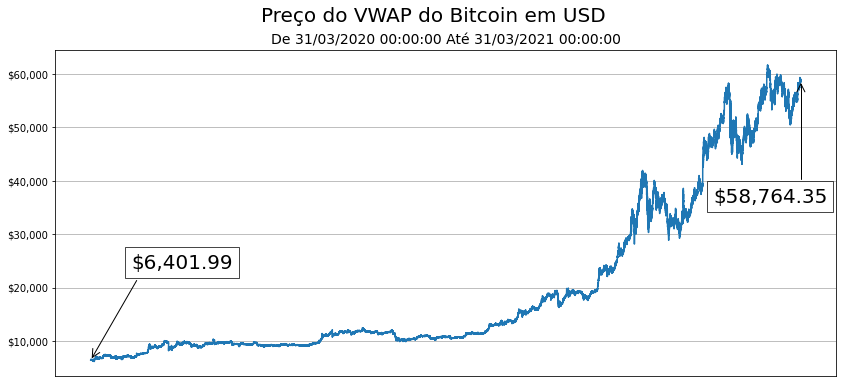

In [7]:
def figureCloses(data, createFigure=True, showAnnotate=True, subtitle="Preço de Fechamento do Bitcoin em USD", fontsize=20, mask_yaxis='${x:,.0f}'):
    if createFigure:
        plt.figure(figsize=(14, 6))

    plt.suptitle(subtitle, fontsize=fontsize)
    plt.title("De {} Até {}".format(
        firstTimestamp, lastTimestamp), fontsize=14)
    plt.grid()
    plt.plot(data)
    ax = plt.gca()

    if showAnnotate:
        annot_max(0, data[0],
                  30000, 20000, "angle,angleA=0,angleB=60", ax)
        annot_max(len(data), data[-1],
                  -65000, -20000, "angle,angleA=0,angleB=-90", ax)

    ax.get_xaxis().set_visible(False)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(mask_yaxis))


def figureVolumeBtc(data, createFigure=True, showAnnotate=True, subtitle="Volume de movimentações do Bitcoin"):
    if createFigure:
        plt.figure(figsize=(7, 3))

    plt.suptitle(subtitle, fontsize=20)
    # plt.title("De {} Até {}".format(
    #     firstTimestamp, lastTimestamp), fontsize=14)
    plt.grid()
    plt.plot(data)
    ax = plt.gca()

    data2 = np.vectorize(lambda x: x if x >= 0 else 0)(data)
    index = np.argmax(data2)
    if showAnnotate:
        annot_max(index, data2[index],
                  100000, 0, "angle,angleA=0,angleB=-5", ax)
        # annot_max(len(data), data[-1],
        #           -65000, -20000, "angle,angleA=0,angleB=-90", ax)

    ax.get_xaxis().set_visible(False)


kw = dict(showAnnotate=True, createFigure=True)

attr = [
    # 'open',
    # 'high',
    # 'low',
    # 'close',
    'weightedPrice',
    # 'volume_Btc',
    # 'volume_Currency'
]

for att in attr:
    figureCloses(filteredObject[att],subtitle="Preço do VWAP do Bitcoin em USD", **kw)


# figureCloses(filteredObject['weightedPrice'],subtitle="VWAP", **kw)
# figureCloses(filteredObject['close'], **kw)


In [10]:
filteredObject['time'] = np.vectorize(lambda x: mdates.date2num(datetime.fromtimestamp(x)))(filteredObject['timestamp'])

KeyboardInterrupt: 

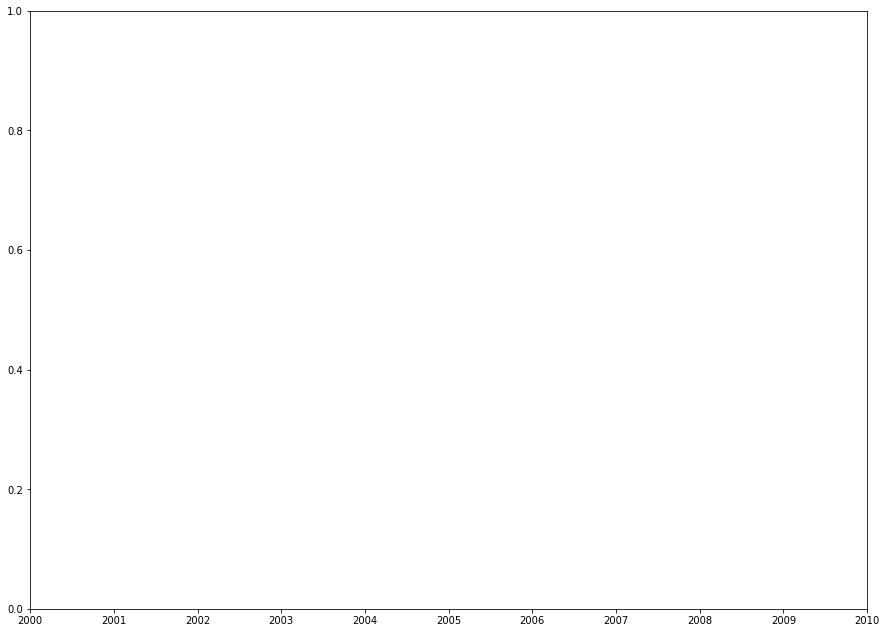

In [16]:

# attr = [
#     # 'open',
#     # 'high',
#     # 'low',
#     'close',
#     'weightedPrice',
#     # 'volume_Btc',
#     # 'volume_Currency'
# ]


data = []
for index in range(len(filteredObject['time'])):
    sub_lst = filteredObject['time'][index], filteredObject['open'][index], filteredObject[
        'high'][index], filteredObject['low'][index], filteredObject['close'][index]
    data.append(sub_lst)

# OHLCfiltered_df = filteredObject[['date', 'open', 'high', 'low', 'close']]

f, ax = plt.subplots(figsize=(15, 11))
ax.xaxis_date()
candlestick_ohlc(ax, data, width=0.5,
                 colorup='g', colordown='r', alpha=0.75)

plt.xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title(name + " price")
plt.ylabel("Price")
plt.show()


Transforming time series data to trainable data

In [47]:
# normalização dos dados
closes = filteredObject['close']
close_price = np.array(closes).reshape(-1,1)
sc = MinMaxScaler()
close_priceSC = sc.fit_transform(close_price)

X = []
y = []
a = range(60, len(close_priceSC))
for i in range(60, len(close_priceSC)):
    X.append(close_priceSC[i-60:i, 0])
    y.append(close_priceSC[i, 0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape, len(closes))


(525541, 60) (525541,) 525601


Splitting train and test

In [54]:
# Separar Dados de Treino e Teste
limitTrain = int((len(X) * 0.98))

X_train = X[:limitTrain, :]
X_test = X[limitTrain:, :]

y_train = y[:limitTrain]
y_test = y[limitTrain:]

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

willPredictInDays = len(y_test) / 60 / 24
print("Previsão aproximada de {0:g} dias".format(round(willPredictInDays, 0)))

Previsão aproximada de 7 dias


Plotting train and test data

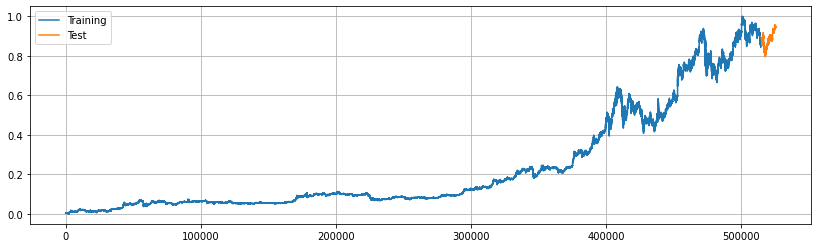

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(range(limitTrain), y_train)
plt.plot(range(limitTrain, len(y)), y_test)
plt.legend(["Treinamento", "Teste"])
plt.grid()


Preparing X for LSTM

In [44]:
X_train = X_train.reshape(-1, 60, 1)
X_test = X_test.reshape(-1, 60, 1)


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

Train using LSTM 

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True,
              input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=1, batch_size=500)


In [ ]:
y_pred = regressor.predict(X_test)
MSE = mean_absolute_error(y_test, y_pred)


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(sc.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1, 1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")


This is clearly overfitting